# Práctica 1: primera toma de contacto con la optimización no lineal en Python

Los objetivos principales de esta primera práctica son:

1) Empezar a familiarizarnos con algunas de las ideas que están continuamente subyacentes a los problemas de optimización no lineal. Entre otros, cabe destacar: existencia de solución, unicidad, convexidad, coercividad, importancia de la inicialización en algoritmos iterativos, etc..

2) Tener una primera toma de contacto con el submódulo **optimize** del módulo **scipy** de Python, donde aparecen implemetados un buen número del algoritmos de optimización, una buena parte de los cuales estudiaremos a lo largo de este curso.
El enlace a la API de dicho módulo es [scipy.optimize API](https://docs.scipy.org/doc/scipy/reference/optimize.html) 

La optimización no lineal juega un papel crucial en Machine Learning. En efecto, entrenar un modelo de predicción consiste en resolver un problema de optimización. Es por ello que no sólo en **scipy.optimize** aparecen implementados algoritmos de optimización. En el módulo **scikit-learn**, dedicado a Machine Learning, se utilizan algunos de los algoritmos y estrategias de optimización más usados en este campo de la Inteligencia Artificial. Como muestra, puede consultarse la [sklearn.neural_network.MLPClassifier API](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html?highlight=adam), donde aparecen implementados un algoritmo de descenso estocástico y dos de sus versiones aceleradas más usadas: ADAM y L-BFGS.

## 1.1 Existencia de solución, coercividad y regularización

Consideremos el siguiente problema de programación no lineal sin restricciones:

$$
\text{Minimizar en } x\in\mathbb{R}:\quad f(x) = \left(\tanh(x) - 1\right)^2
$$

Este problema de optimización se corresponde con el llamado **proceso de entrenamiento** del siguiente modelo de red neuronal:
$$
\sigma(\omega x + b),
$$
para el conjunto de dato(s) $ (0, 1)$ y función de activación $\sigma(s) = \tanh(s)$.
$\omega$ y $b$ son los parámetros de la red que hay que ajustar.



De entre la gran variedad de métodos que aparecen en **scipy.optime** para resolver 
este tipo de problemas escalares, vamos a usar el método [minimize_scalar](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize_scalar.html#scipy.optimize.minimize_scalar)

In [4]:
# importamos **minimize_scalar** del submódulo optimize del módulo scipy
from scipy.optimize import minimize_scalar
# y por supuesto el módulo numpy
import numpy as np

# definimos la función objetivo del problema
def f(x):
    return (np.tanh(x) -1) ** 2

# y ahora optimizamos
 
res = minimize_scalar(f)
print(f"solución x = {res.x}")

solución x = 45.36068049995748


Acabamos de usar la función **minimize_scalar** como una caja negra!. Por supuesto, 
una de las cualidades más importantes de un **científico de datos** es tener (y saber usar) 
herramientas que le permitan tener un criterio acertado sobre los resultados 
que se obienen. Así pues, vamos a analizar con más detalle este problema.

Por defecto, **minimize_scalar** usa un método de optimización llamado de **Brent**.
Permite usar otros métodos, como el **golden**. Vamos qué pasa si usamos este otro método.

In [5]:
res_2 = minimize_scalar(f, method='golden')
print(f"solución x = {res_2.x}")

solución x = 18.99034124620993


Observamos que obtenemos una solución distinta!

Dado que la función objetivo es de una dimensión, la primera opción para averiguar qué está pasando es dibujarla.

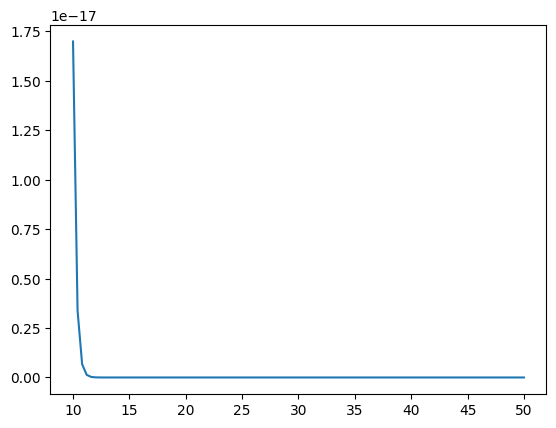

In [6]:
import matplotlib.pyplot as plt

x = np.linspace(10, 50, 100)
plt.plot(x, f(x))

plt.show()

Y si cogemos la lupa para averiguar qué sucede cerca de las dos soluciones anteriores y también alrededor de $x = 10$

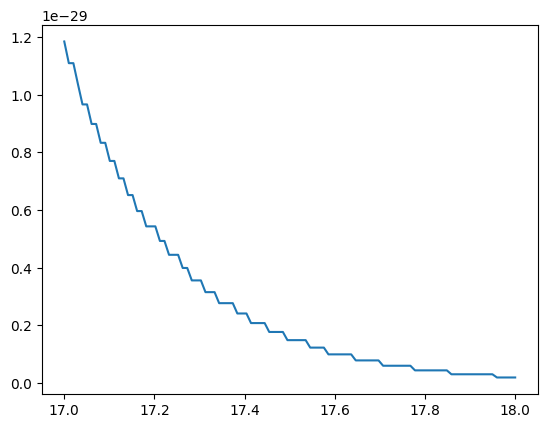

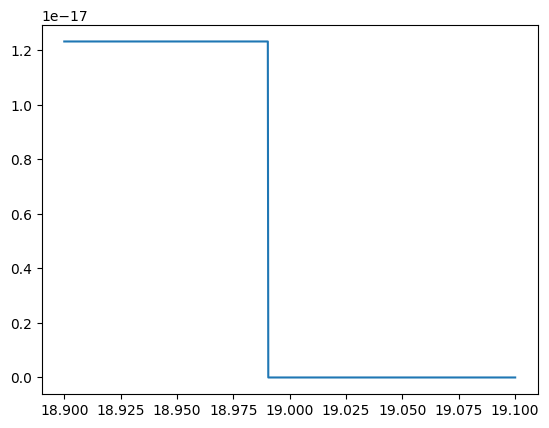

In [7]:
# en un entorno  de x = 45.36
#x = np.linspace(45.35, 45.37, 100)
x = np.linspace(17, 18, 100)
plt.plot(x, f(x))

plt.show()

# y de x = 19.06
x = np.linspace(18.9, 19.1, 1000)
plt.plot(x, 1e15 * f(x))

plt.show()

Observamos que nos movemos en una escala del $\epsilon$ de la máquina por lo que 
los resultados gráficos no son concluyentes, pero podemos intuir que la función que 
estamos minimizando hace asíntota hacia cero cuando $x\rightarrow\infty$, lo que significa que no existe mínimo. Nótese que la función objetivo es continua pero **no es coerciva**, es decir, 
no va a infinito cuando $\vert x\vert\rightarrow\infty$. Éste es uno de los principales motivos de **no existencia de solución**. 

Bien es cierto que en este ejemplo concreto nos podríamos contentar con cualquiera de las dos soluciones anteriores pues en ambos casos el valor de la función objetivo está muy cerca de dar el valor óptimo de cero.  

Una forma habitual de superar esta dificultad (no existencia de solución) consiste en añadir un término adicional a la función objetivo, típicamente un término cuadrático. Es lo que se llama **regularizar** la función objetivo. Veamos cómo hacerlo:

In [8]:
def f_reg(x):
    alpha = 10
    return (np.tanh(x) -1) ** 2 + alpha * x ** 2


$\alpha$ es el llamado parámetro de regularización. En el modelo de ML asociado a este problema, introducir este término de regularización se corresponde con añadir la norma $2$ al cuadrado de los parámetros de la red, es decir 
$\Vert (\omega, b)\Vert^2_2$. Nótese que $\omega$ no juega ningún papel por lo que hemos tomado $\omega = 0$ para el proceso de entrenamiento. La optimización y el Machine Learning tienen mucho de **tuneo (tunning)** de parámetros. En concreto, $\alpha$ es lo que se llama un **hiper-parámetro** y tunear significa que se ha de adaptar el valor de $\alpha$ al objetivo que se persiga en cada caso.

Resolvemos ahora nuestro problema de optimización para f_reg.

In [9]:
res = minimize_scalar(f_reg)
print(f"solución x = {res.x}")

solución x = 0.09026097413962376


Podemos ver cómo cambia el valor de la solución al cambiar el valor de $\alpha$.

Dibujamos ahora  f_reg cerca de la solución obtenida.

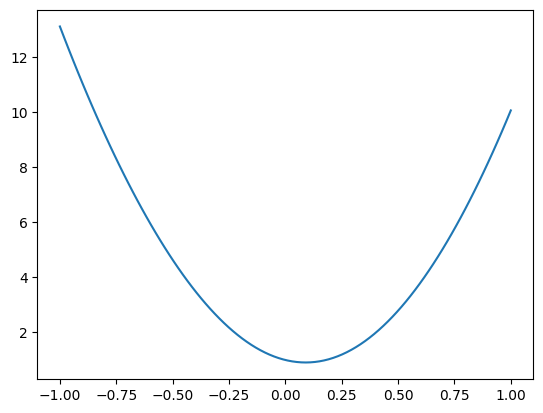

In [10]:
x = np.linspace(-1, 1, 100)
plt.plot(x, f_reg(x))

plt.show()

## 1.2 Mínimos locales, inicialización y criterio de parada

Consideremos ahora como función objetivo $f(x) = (x^2-1)^2$, que es continua y también coerciva. Por tanto, la existencia de mínimo está garantizada.

In [11]:
def objetivo(x):
    return (x ** 2 -1) ** 2

In [12]:
# Minimizamos esta función tomando como inicialización (initial guess) x = -2
# Para ello, importaremos **minimize** y usaremos un método de segundo orden 
# (todo esto lo veremos en detalle más adelante)
from scipy.optimize import minimize
x0 = -3
res = minimize(objetivo, x0, method='BFGS', 
                options={'gtol': 1e-6, 'disp': True})
print(f"solución x = {res.x}")

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 9
         Function evaluations: 20
         Gradient evaluations: 10
solución x = [-1.00000002]


In [13]:
# Probamos ahora otras inicializaciones
x0 = 0
res = minimize(objetivo, x0, method='BFGS', 
                options={'gtol': 1e-6, 'disp': True})
print(f"solución x = {res.x}")


Optimization terminated successfully.
         Current function value: 1.000000
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
solución x = [0.]


In [14]:
x0 = 3
res = minimize(objetivo, x0, method='BFGS', 
                options={'gtol': 1e-6, 'disp': True})
print(f"solución x = {res.x}")

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 9
         Function evaluations: 20
         Gradient evaluations: 10
solución x = [1.]


Observamos que en todos los casos parece que la optimización ha tenido éxito.
El algorotmo se ha detenido cuando la norma $2$ del gradiente 
ha tomado un valor menor o igual a gtol = 1e-6.

En el primer y tercer caso, el valor de la función objetivo, después de la convergencia, 
ha dado el valor cero, y en el segundo caso $1$.

Para entender mejor lo que ha sucedido vamos a dibujar la función objetivo.

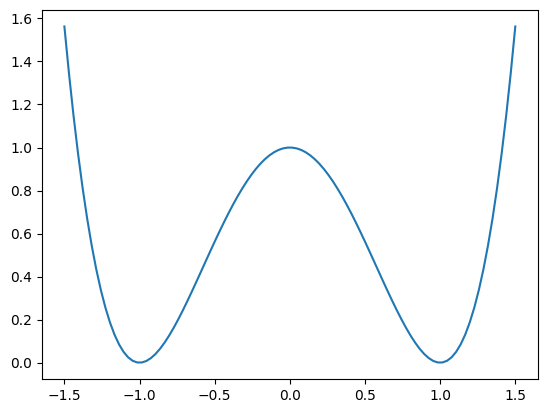

In [15]:
x = np.linspace(-1.5, 1.5, 100)
plt.plot(x, objetivo(x))

plt.show()

Observamos que, en efecto, en $x=-1$ y en $x=1$ hay dos mínimo locales, que además resultan ser globales. 
Sin embargo, en $x = 0$ hay un máximo local.

En los tres casos, el algoritmo ha parado porque el gradiente se ha anulado,
pero la gran diferencia es que la función objetivo en convexa en un entorno de 
$x = -1$ y $x = 1$, mientras que en $x = 0$ no es convexa.

Este ejemplo pone de manifiesto algunos aspectos clave de la optimización no lineal.
A saber: importancia de la **inicialización**, del **criterio de parada**, y del papel clave de la 
**convexidad**.